# Week 01 — Galway population by age (City + County)

This notebook loads the CSO `cso-populationbyage.csv`, filters the two Galway councils for CensusYear 2022 (both sexes), aggregates by single-year age, and visualises the age structure.

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Find CSV (search nearby data/ folders)
FNAME = 'cso-populationbyage.csv'
def find_csv(start: Path, name: str, levels: int = 4) -> Path | None:
    p = start.resolve()
    for _ in range(levels):
        if (p / 'data' / name).exists():
            return p / 'data' / name
        if (p / 'code' / 'data' / name).exists():
            return p / 'code' / 'data' / name
        p = p.parent
    return None

csv_path = find_csv(Path('.'), FNAME) or find_csv(Path.cwd(), FNAME)
if csv_path is None:
    raise FileNotFoundError(f"Put '{FNAME}' in a nearby data/ folder")
print('Using:', csv_path)

Using: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\my-work\data\cso-populationbyage.csv


In [3]:
df = pd.read_csv(csv_path)
# Filter to CensusYear 2022, Galway City + County, Both sexes
df['CensusYear'] = pd.to_numeric(df['CensusYear'], errors='coerce') if 'CensusYear' in df.columns else None
galway_names = ['Galway City Council', 'Galway County Council']
mask = (pd.to_numeric(df['CensusYear'], errors='coerce') == 2022) & (df['Administrative Counties'].isin(galway_names)) & (df['Sex'].astype(str) == 'Both sexes')
df_gal = df[mask].copy()
print('Rows selected:', len(df_gal))

# Parse ages (Under 1 -> 0)
def parse_age(s):
    if not isinstance(s, str):
        return None
    s = s.strip()
    if s.lower().startswith('under'):
        return 0
    if s.lower() == 'all ages':
        return None
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else None

# Build aggregated series by age
df_gal['AgeNum'] = df_gal['Single Year of Age'].apply(parse_age)
df_gal = df_gal.dropna(subset=['AgeNum']).copy()
df_gal['AgeNum'] = df_gal['AgeNum'].astype(int)
df_gal['VALUE'] = pd.to_numeric(df_gal['VALUE'], errors='coerce')
df_age = df_gal.dropna(subset=['VALUE']).sort_values('AgeNum')
agg = df_age.groupby('AgeNum', sort=True)['VALUE'].sum().reset_index()

# Show the five age groups with the highest population counts in Galway (city+county)
top5 = agg.nlargest(5, 'VALUE').reset_index(drop=True)

# For each decade (20s, 30s, 40s, 50s) find the age with the highest population
decades = [(20,29,'20s'), (30,39,'30s'), (40,49,'40s'), (50,59,'50s')]
rows = []
for start, end, label in decades:
    subset = agg[(agg['AgeNum'] >= start) & (agg['AgeNum'] <= end)]
    if subset.empty:
        rows.append({'Decade': label, 'Age': None, 'Population': None})
    else:
        top_row = subset.loc[subset['VALUE'].idxmax()]
        rows.append({'Decade': label, 'Age': int(top_row['AgeNum']), 'Population': int(top_row['VALUE'])})

decade_df = pd.DataFrame(rows)

# Display results
print('\nTop 5 ages by population:')
print(top5.to_string(index=False))

def display_df(df):
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df)

print('\nHighest age within each decade (20s,30s,40s,50s):')
display_df(decade_df)


Rows selected: 204

Top 5 ages by population:
 AgeNum  VALUE
     42   4570
     41   4562
     40   4489
     39   4332
     43   4294

Highest age within each decade (20s,30s,40s,50s):


,Decade,Age,Population
0,20s,20,4076
1,30s,39,4332
2,40s,42,4570
3,50s,51,3842


Saved: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\my-work\generated_charts\cso-populationbyage_galway_2025-10-06_124832.png


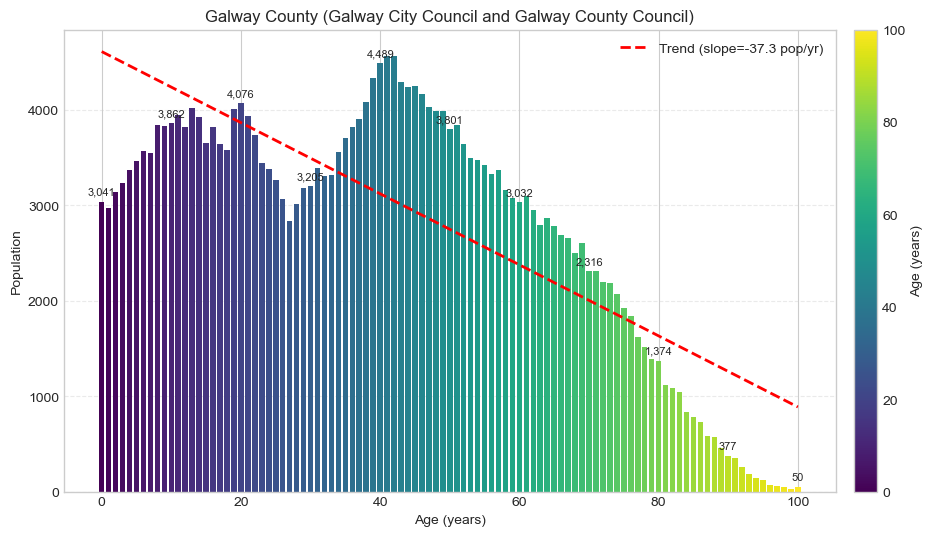

In [4]:
# Plot with per-age colours, annotations every 10 years, and trend line
fig, ax = plt.subplots(figsize=(12,6))
ages = agg['AgeNum'].to_numpy()
vals = agg['VALUE'].to_numpy()
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=ages.min(), vmax=ages.max())
colors = cmap(norm(ages))
bars = ax.bar(ages, vals, color=colors, width=0.8)
ax.set_xlabel('Age (years)')
ax.set_ylabel('Population')
ax.set_title('Galway County (Galway City Council and Galway County Council)')
ax.grid(axis='y', linestyle='--', alpha=0.4)
# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02).set_label('Age (years)')

# Annotations every 10 years
y_min, y_max = ax.get_ylim()
y_span = y_max - y_min
y_offset = y_span * 0.01
for age, val, bar in zip(ages, vals, bars):
    if int(age) % 10 == 0:
        ax.text(age, val + y_offset, f'{int(val):,}', ha='center', va='bottom', fontsize=8)

# Trend line
if len(ages) >= 2:
    coeffs = np.polyfit(ages, vals, 1)
    fitted = np.polyval(coeffs, ages)
    ax.plot(ages, fitted, color='red', linestyle='--', linewidth=2, label=f'Trend (slope={coeffs[0]:.1f} pop/yr)')
    ax.legend(loc='upper right')

# Save figure (timestamped) and show
out_dir = None
for anc in Path(csv_path).parents:
    if anc.name == 'my-work':
        out_dir = anc / 'generated_charts'
        break
if out_dir is None and len(Path(csv_path).parents) >= 2:
    out_dir = Path(csv_path).parents[1] / 'generated_charts'
if out_dir is None:
    out_dir = Path.cwd() / 'generated_charts'
out_dir.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime('%Y-%m-%d_%H%M%S')
fname = f'cso-populationbyage_galway_{ts}.png'
fig.savefig(out_dir / fname, dpi=150, bbox_inches='tight')
print('Saved:', out_dir / fname)
plt.show()

## Highlight the dip between ages 20–40

The plot above shows a noticeable dip in population counts between about age 20 and 40. Below we emphasise that region: we shade ages 20–40 and compute the relative drop compared to neighbouring age bands.

Saved highlight: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\my-work\generated_charts\cso-populationbyage_galway_highlight_2025-10-06_124832.png


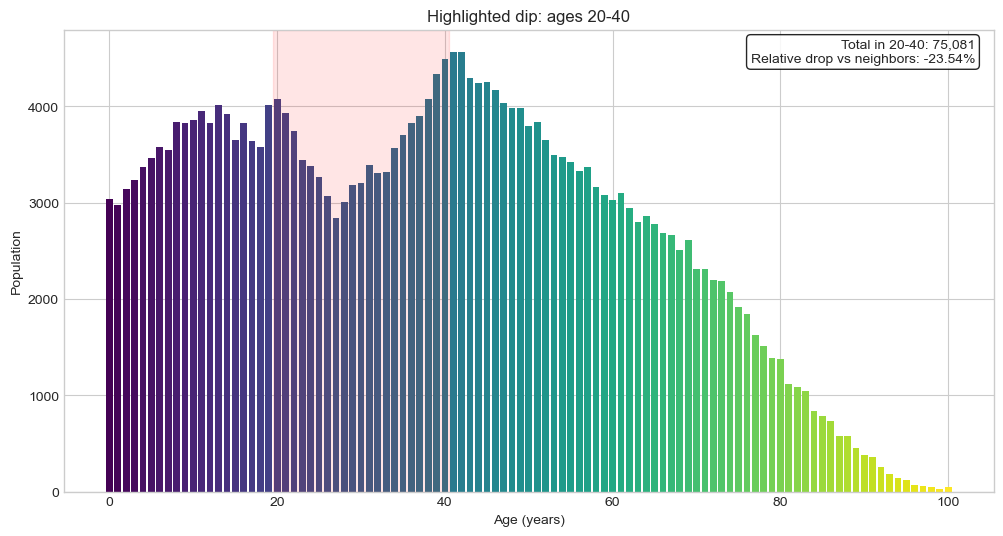

In [5]:
# Shade ages 20-40 and compute summary stats
low, high = 20, 40
mask_range = (agg['AgeNum'] >= low) & (agg['AgeNum'] <= high)
sum_range = agg.loc[mask_range, 'VALUE'].sum()
sum_left = agg.loc[agg['AgeNum'] < low, 'VALUE'].sum()
sum_right = agg.loc[agg['AgeNum'] > high, 'VALUE'].sum()
avg_neighbors = ((sum_left / max(1, (agg['AgeNum'] < low).sum())) + (sum_right / max(1, (agg['AgeNum'] > high).sum()))) / 2
rel_drop = 1 - (sum_range / (avg_neighbors * max(1, mask_range.sum())))

fig2, ax2 = plt.subplots(figsize=(12,6))
bars2 = ax2.bar(agg['AgeNum'], agg['VALUE'], color=colors, width=0.8)
ax2.axvspan(low - 0.5, high + 0.5, color='red', alpha=0.1)
ax2.set_xlabel('Age (years)')
ax2.set_ylabel('Population')
ax2.set_title(f'Highlighted dip: ages {low}-{high}')
# put a small annotation box with the computed stats
stats = [f'Total in {low}-{high}: {int(sum_range):,}', f'Relative drop vs neighbors: {rel_drop:.2%}']
props = dict(boxstyle='round', facecolor='white', alpha=0.85)
ax2.text(0.98, 0.98, '\n'.join(stats), transform=ax2.transAxes, fontsize=10, va='top', ha='right', bbox=props)
fig2.savefig(out_dir / f'cso-populationbyage_galway_highlight_{ts}.png', dpi=150, bbox_inches='tight')
print('Saved highlight:', out_dir / f'cso-populationbyage_galway_highlight_{ts}.png')
plt.show()